In [16]:
import fitz
import os

# Open the input PDF
input_pdf = "practice-bbs-as-per-mostamph_compress.pdf"
doc = fitz.open(input_pdf)

# Define an output PDF with the same dimensions
outpdf = fitz.open()

# Loop through all the pages in the input PDF
for page_num in range(len(doc)):
    page = doc[page_num]

    # Extract existing drawings
    paths = page.get_drawings()

    # Create a new page in the output PDF
    outpage = outpdf.new_page(width=page.rect.width, height=page.rect.height)
    shape = outpage.new_shape()

    # Loop through the paths and draw them on the new page
    for path in paths:
        for item in path["items"]:
            if item[0] == "l":  # line
                shape.draw_line(item[1], item[2])
            elif item[0] == "re":  # rectangle
                shape.draw_rect(item[1])
            elif item[0] == "qu":  # quad
                shape.draw_quad(item[1])
            elif item[0] == "c":  # curve
                shape.draw_bezier(item[1], item[2], item[3], item[4])
            else:
                raise ValueError("Unhandled drawing type", item)

        # Finish the path and commit the shape to the page
        shape.finish()

    shape.commit()

# Save the output PDF
output_pdf = "line_extracted1.pdf"
outpdf.save(output_pdf)

# Create the output folder for images if it doesn't exist
output_folder = "Page"
os.makedirs(output_folder, exist_ok=True)

# Open the output PDF and save each page as an image
doc = fitz.open(output_pdf)
mat = fitz.Matrix(2.0, 2.0)

for page_num in range(len(doc)):
    page = doc.load_page(page_num)
    pix = page.get_pixmap(matrix=mat)
    output_filename = f"page_{page_num + 1}.png"
    output_path = os.path.join(output_folder, output_filename)
    pix.save(output_path)
    print(f"Extracted image saved at: {output_path}")

print(f"All extracted images are saved in the '{output_folder}' folder.")


Extracted image saved at: Page\page_1.png
Extracted image saved at: Page\page_2.png
All extracted images are saved in the 'Page' folder.


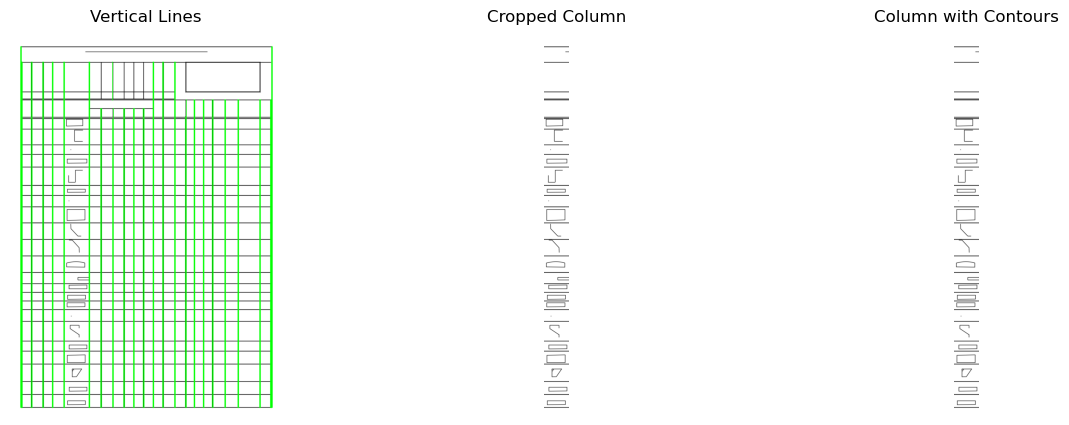

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image using OpenCV
img_path = "Page/page_1.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred_img, 50, 150, apertureSize=3)

# Find contours using hierarchical contouring
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Detect lines using probabilistic Hough transform
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

# Draw lines on a copy of the original image
lines_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
vertical_lines = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(x1 - x2) < abs(y1 - y2):
            cv2.line(lines_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            vertical_lines.append(int((x1 + x2) / 2))

# Sort vertical line x-coordinates
vertical_lines.sort()

# Function to filter out contours that are too close to vertical lines
def filter_contours(contours, x1, x2, margin=5):
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x1 + margin < x < x2 - margin:
            filtered_contours.append(contour)
    return filtered_contours

# Variable to store the column with the most contours
max_contours = 0
best_column_img = None
best_column_contours = None
best_x1 = 0
best_x2 = 0

# Iterate over pairs of vertical lines to find contours between them
for i in range(len(vertical_lines) - 1):
    x1 = vertical_lines[i]
    x2 = vertical_lines[i + 1]

    # Filter contours within the current column
    column_contours = filter_contours(contours, x1, x2)

    # If this column has more contours, update the best column
    if len(column_contours) > max_contours:
        max_contours = len(column_contours)
        best_column_img = img[:, x1:x2]
        best_column_contours = column_contours
        best_x1 = x1
        best_x2 = x2

# Plot the images side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image with detected vertical lines
axes[0].imshow(lines_img)
axes[0].set_title('Vertical Lines')
axes[0].axis('off')

if best_column_img is not None:
    # Cropped column with contours
    axes[1].imshow(best_column_img, cmap='gray')
    axes[1].set_title('Cropped Column')
    axes[1].axis('off')

    # Column with drawn contours
    best_column_contour_img = cv2.cvtColor(best_column_img, cv2.COLOR_GRAY2BGR)
    for contour in best_column_contours:
        cv2.drawContours(best_column_contour_img, [contour], -1, (0, 255, 0), 2)

    axes[2].imshow(best_column_contour_img)
    axes[2].set_title('Column with Contours')
    axes[2].axis('off')
    cv2.imwrite(f"cropped_column.png", best_column_img)

plt.show()

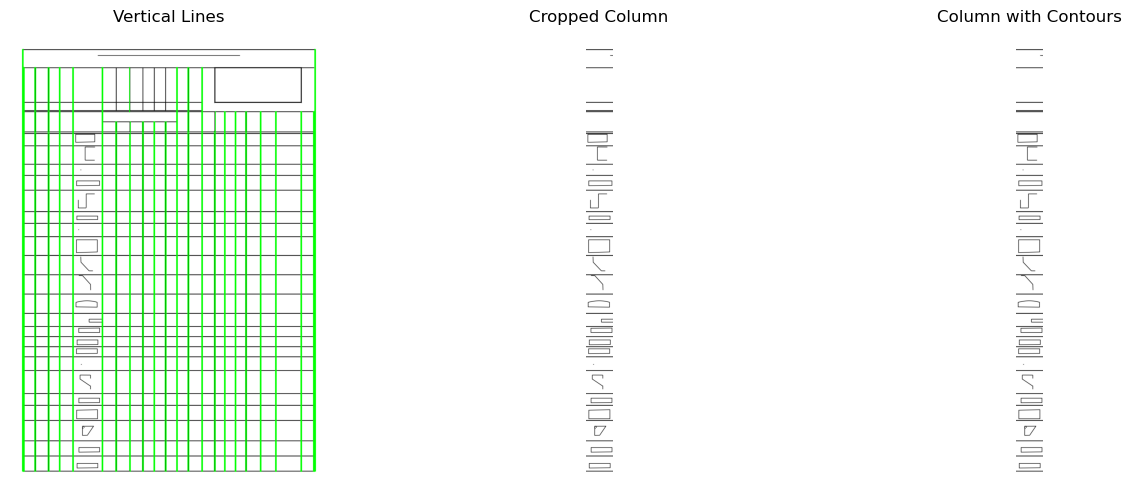

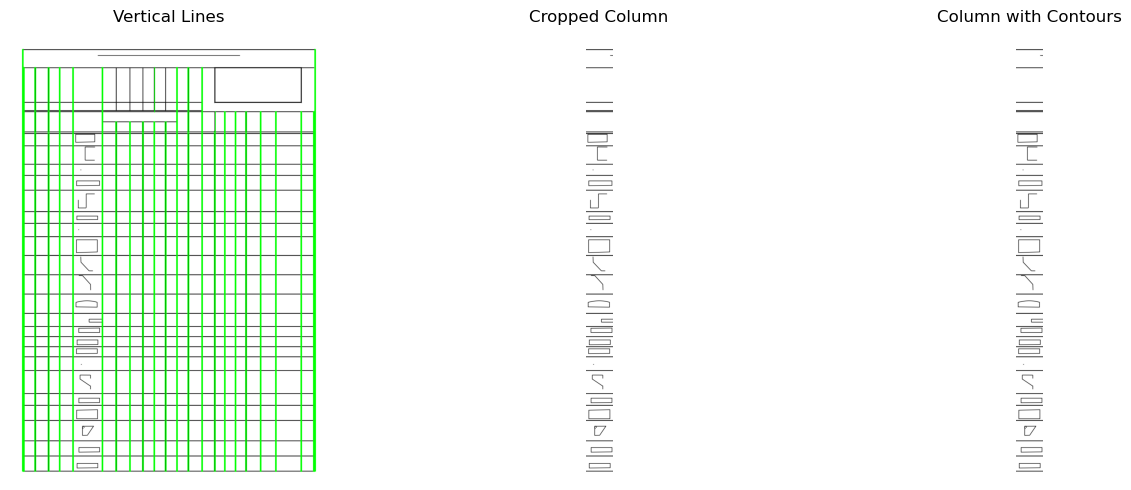

In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define input and output directories
input_dir = "Page"
output_dir = "CC"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to process each image
def process_image(img_path):
    # Read the image using OpenCV
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian blur to reduce noise
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred_img, 50, 150, apertureSize=3)

    # Find contours using hierarchical contouring
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Detect lines using probabilistic Hough transform
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

    # Draw lines on a copy of the original image
    lines_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    vertical_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x1 - x2) < abs(y1 - y2):
                cv2.line(lines_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                vertical_lines.append(int((x1 + x2) / 2))

    # Set minimum distance between vertical lines
    min_distance = 10  # Adjust this value as per your requirement

    # Sort vertical line x-coordinates
    vertical_lines.sort()

    # Filter out consecutive lines that are too close
    filtered_vertical_lines = [vertical_lines[0]]
    for i in range(1, len(vertical_lines)):
        if vertical_lines[i] - filtered_vertical_lines[-1] > min_distance:
            filtered_vertical_lines.append(vertical_lines[i])

    # Variable to store the column with the most contours
    max_contours = 0
    best_column_img = None
    best_column_contours = None
    best_x1 = 0
    best_x2 = 0

    # Iterate over pairs of vertical lines to find contours between them
    for i in range(len(filtered_vertical_lines) - 1):
        x1 = filtered_vertical_lines[i]
        x2 = filtered_vertical_lines[i + 1]

        # Apply a margin to avoid including the vertical line
        margin = 5  # Adjust this value based on the thickness of the line
        x1 += margin
        x2 -= margin

        # Filter contours within the current column
        column_contours = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if x1 + min_distance < x < x2 - min_distance:
                column_contours.append(contour)

        # If this column has more contours, update the best column
        if len(column_contours) > max_contours:
            max_contours = len(column_contours)
            best_column_img = img[:, x1:x2]
            best_column_contours = column_contours
            best_x1 = x1
            best_x2 = x2

    # Prepare output filenames
    img_name = os.path.basename(img_path)
    output_img_path = os.path.join(output_dir, img_name)

    # Save the processed image
    if best_column_img is not None:
        cv2.imwrite(output_img_path, best_column_img)

    return lines_img, best_column_img, best_column_contours

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".png") or filename.endswith(".jpg"):  # Adjust file extensions as needed
        img_path = os.path.join(input_dir, filename)

        # Process the image
        lines_img, cropped_img, contours = process_image(img_path)

        # Plot and show the images side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original image with detected vertical lines
        axes[0].imshow(lines_img)
        axes[0].set_title('Vertical Lines')
        axes[0].axis('off')

        if cropped_img is not None:
            # Cropped column with contours
            axes[1].imshow(cropped_img, cmap='gray')
            axes[1].set_title('Cropped Column')
            axes[1].axis('off')

            # Column with drawn contours
            best_column_contour_img = cv2.cvtColor(cropped_img, cv2.COLOR_GRAY2BGR)
            for contour in contours:
                cv2.drawContours(best_column_contour_img, [contour], -1, (0, 255, 0), 2)

            axes[2].imshow(best_column_contour_img)
            axes[2].set_title('Column with Contours')
            axes[2].axis('off')

        plt.tight_layout()
        plt.show()


Number of saved rows: 39


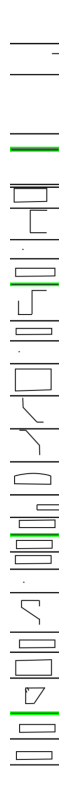

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def is_image_blank(image, blank_threshold=0.98, min_non_blank_pixels=100):
    # Calculate the percentage of white pixels in the image
    white_pixels = np.sum(image >= 200)  # Assuming white pixels have intensity >= 200
    total_pixels = image.size
    white_ratio = white_pixels / total_pixels

    # Check if the image has a large enough percentage of white pixels to be considered blank
    if white_ratio > blank_threshold:
        # Check if there are enough non-blank pixels to avoid mistakenly removing data rows
        non_blank_pixels = total_pixels - white_pixels
        if non_blank_pixels < min_non_blank_pixels:
            return True  # Image is considered blank
    return False  # Image is not blank

# Read the cropped column image
cropped_column_img = cv2.imread("cropped_column.png", cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
blurred_img = cv2.GaussianBlur(cropped_column_img, (5, 5), 0)

# Apply adaptive thresholding to binarize the image
binary_image_adaptive = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 5)

# Apply morphological closing to connect nearby edges and smoothen the lines
kernel = np.ones((3, 3), np.uint8)
closed_img = cv2.morphologyEx(binary_image_adaptive, cv2.MORPH_CLOSE, kernel)

# Find horizontal lines using morphological operations
horizontal_lines = cv2.morphologyEx(closed_img, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours of horizontal lines
contours, _ = cv2.findContours(horizontal_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter horizontal lines based on length and horizontal coverage
filtered_lines = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 0.9 * cropped_column_img.shape[1]:  # Check if line spans entire width
        filtered_lines.append(contour)

# Sort filtered lines by y-coordinate
filtered_lines.sort(key=lambda c: cv2.boundingRect(c)[1])

# Define the output folder
output_folder = "Shapes"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to crop and save rows
def crop_and_save_rows(lines):
    for i in range(len(lines) - 1):
        x1, y1, w1, h1 = cv2.boundingRect(lines[i])
        x2, y2, w2, h2 = cv2.boundingRect(lines[i + 1])

        # Crop the region between two horizontal lines
        row_img = cropped_column_img[y1 + h1 : y2, :]

        # Check if the cropped row has sufficient width and is not blank
        if row_img.shape[1] > 5 and not is_image_blank(row_img):
            # Save the cropped row image
            cv2.imwrite(os.path.join(output_folder, f"row_{i + 1}.png"), row_img)

# Crop and save rows
crop_and_save_rows(filtered_lines)

# Print the number of saved rows
num_rows_saved = len(os.listdir(output_folder))
print(f"Number of saved rows: {num_rows_saved}")

# Draw the filtered horizontal lines on a copy of the original image
lines_img = cv2.cvtColor(cropped_column_img, cv2.COLOR_GRAY2BGR)
for line in filtered_lines:
    x, y, w, h = cv2.boundingRect(line)
    cv2.rectangle(lines_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with filtered horizontal lines
plt.figure(figsize=(10, 10))
plt.imshow(lines_img)
plt.axis('off')
plt.show()


Number of saved rows for page_1.png: 18


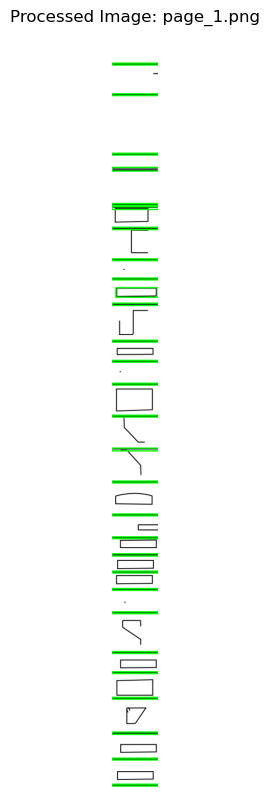

Number of saved rows for page_2.png: 36


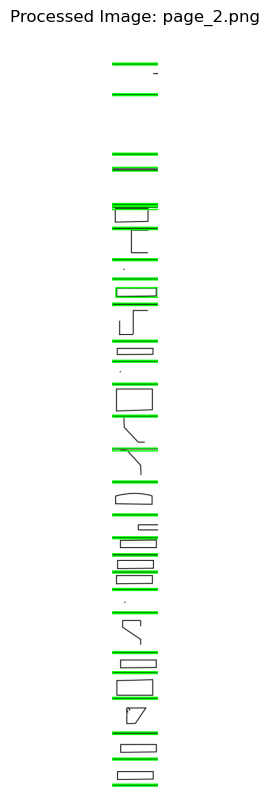

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def is_image_blank(image, blank_threshold=0.98, min_non_blank_pixels=100):
    # Calculate the percentage of white pixels in the image
    white_pixels = np.sum(image >= 200)  # Assuming white pixels have intensity >= 200
    total_pixels = image.size
    white_ratio = white_pixels / total_pixels

    # Check if the image has a large enough percentage of white pixels to be considered blank
    if white_ratio > blank_threshold:
        # Check if there are enough non-blank pixels to avoid mistakenly removing data rows
        non_blank_pixels = total_pixels - white_pixels
        if non_blank_pixels < min_non_blank_pixels:
            return True  # Image is considered blank
    return False  # Image is not blank

def process_image(image_path, output_folder):
    # Read the cropped column image
    cropped_column_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian blur to reduce noise
    blurred_img = cv2.GaussianBlur(cropped_column_img, (5, 5), 0)

    # Apply adaptive thresholding to binarize the image
    binary_image_adaptive = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 5)

    # Apply morphological closing to connect nearby edges and smoothen the lines
    kernel = np.ones((1, 5), np.uint8)
    closed_img = cv2.morphologyEx(binary_image_adaptive, cv2.MORPH_CLOSE, kernel)

    # Find horizontal lines using morphological operations
    horizontal_lines = cv2.morphologyEx(closed_img, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find contours of horizontal lines
    contours, _ = cv2.findContours(horizontal_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter horizontal lines based on length and horizontal coverage
    filtered_lines = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 0.9 * cropped_column_img.shape[1]:  # Check if line spans entire width
            filtered_lines.append(contour)

    # Sort filtered lines by y-coordinate
    filtered_lines.sort(key=lambda c: cv2.boundingRect(c)[1])

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Function to crop and save rows
    def crop_and_save_rows(lines):
        min_row_height = 20  # Set a higher minimum height for valid rows
        min_content_density = 0.01  # Minimum percentage of non-white pixels required

        for i in range(len(lines) - 1):
            x1, y1, w1, h1 = cv2.boundingRect(lines[i])
            x2, y2, w2, h2 = cv2.boundingRect(lines[i + 1])

            # Crop the region between two horizontal lines
            row_img = cropped_column_img[y1 + h1 : y2, :]

            # Check if the cropped row has sufficient height
            if row_img.shape[0] < min_row_height:
                continue  # Skip if the region is too thin

            # Check content density to ensure it's not just a line
            non_white_pixels = np.sum(row_img < 200)
            total_pixels = row_img.size
            content_density = non_white_pixels / total_pixels

            if content_density < min_content_density:
                continue  # Skip if the region doesn't have enough content

            # Save the cropped row image
            row_filename = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_path))[0]}_row_{i + 1}.png")
            cv2.imwrite(row_filename, row_img)

    # Crop and save rows
    crop_and_save_rows(filtered_lines)

    # Print the number of saved rows
    num_rows_saved = len(os.listdir(output_folder))
    print(f"Number of saved rows for {os.path.basename(image_path)}: {num_rows_saved}")

    # Draw the filtered horizontal lines on a copy of the original image
    lines_img = cv2.cvtColor(cropped_column_img, cv2.COLOR_GRAY2BGR)
    for line in filtered_lines:
        x, y, w, h = cv2.boundingRect(line)
        cv2.rectangle(lines_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the image with filtered horizontal lines
    plt.figure(figsize=(10, 10))
    plt.imshow(lines_img)
    plt.axis('off')
    plt.title(f"Processed Image: {os.path.basename(image_path)}")
    plt.show()

# Directory containing input images
input_folder = "CC"

# Output folder for saving processed rows
output_folder = "Shapes"

# Iterate through each image in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        image_path = os.path.join(input_folder, filename)
        process_image(image_path, output_folder)


In [26]:
### Bend Calculation

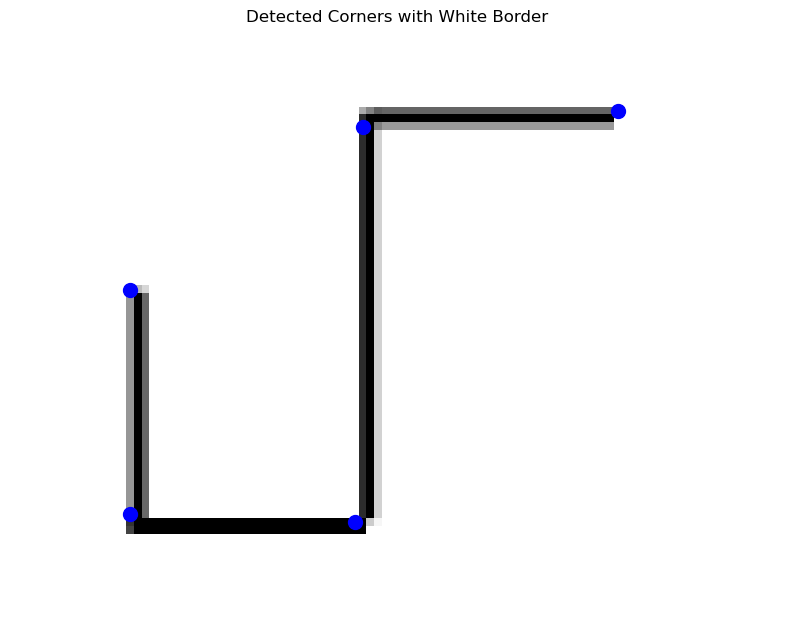

Image: Shapes\page_1_row_11.png
Number of corners detected: 5
Number of bends: 3



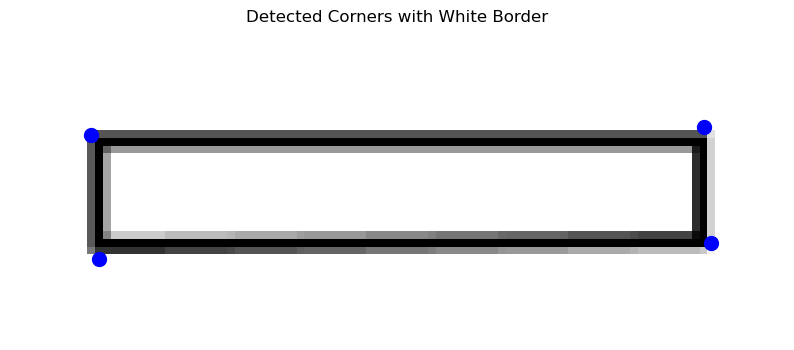

Image: Shapes\page_1_row_12.png
Number of corners detected: 4
Number of bends: 2



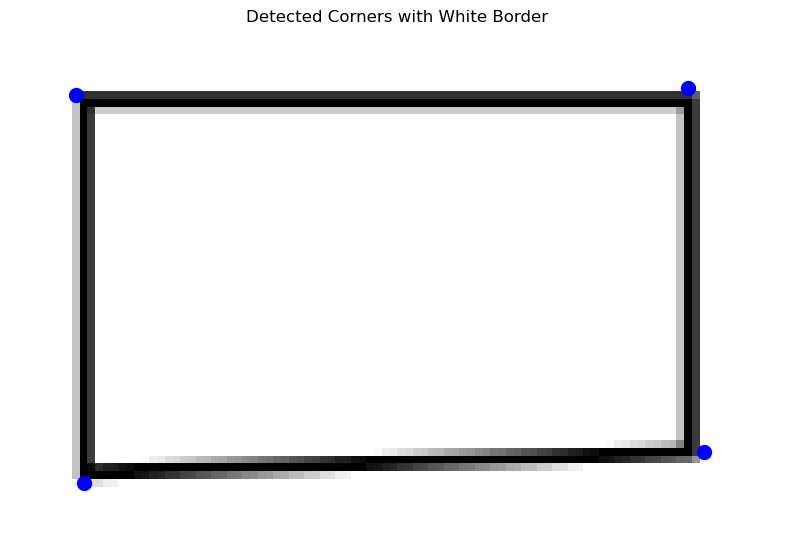

Image: Shapes\page_1_row_14.png
Number of corners detected: 4
Number of bends: 2



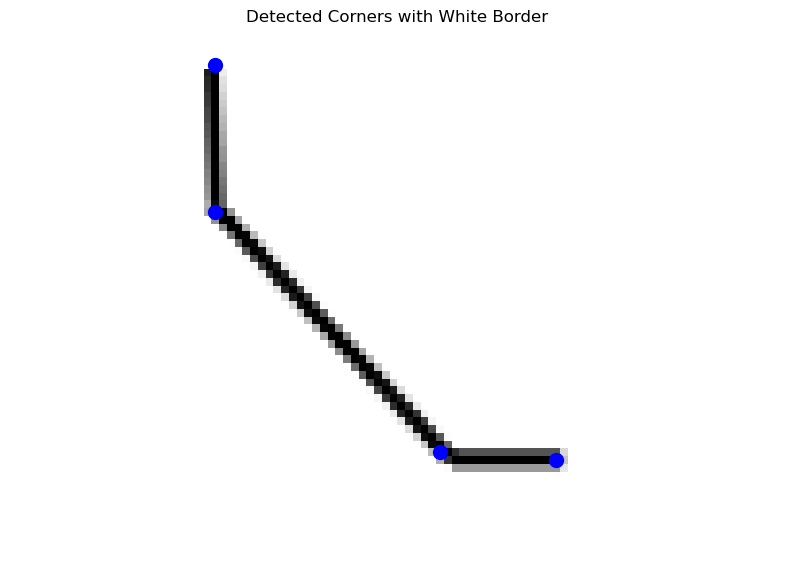

Image: Shapes\page_1_row_15.png
Number of corners detected: 4
Number of bends: 2



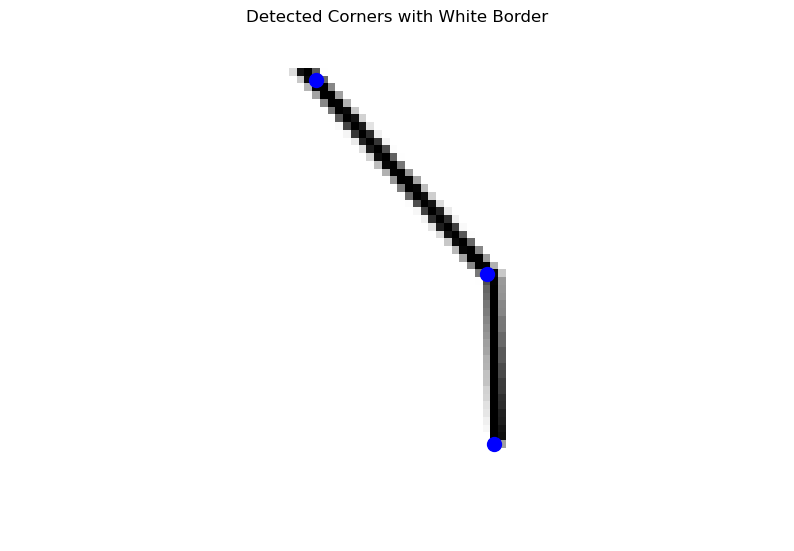

Image: Shapes\page_1_row_16.png
Number of corners detected: 3
Number of bends: 1



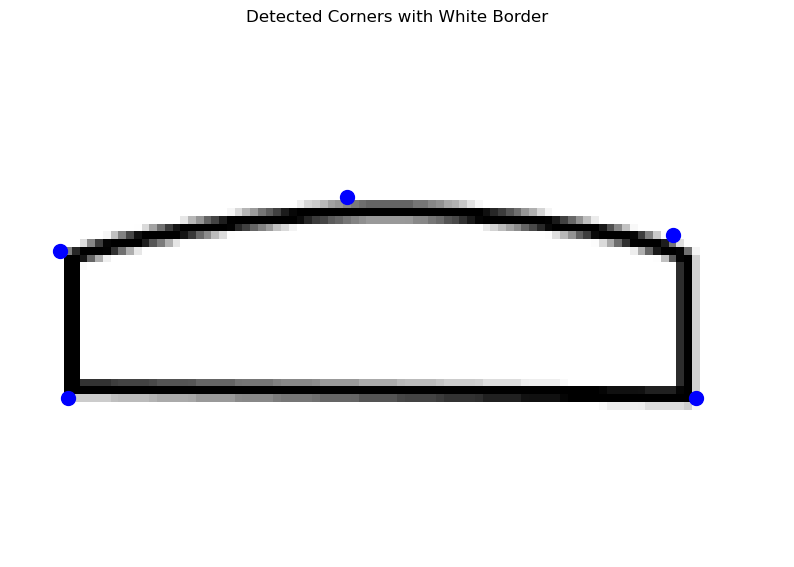

Image: Shapes\page_1_row_17.png
Number of corners detected: 5
Number of bends: 3



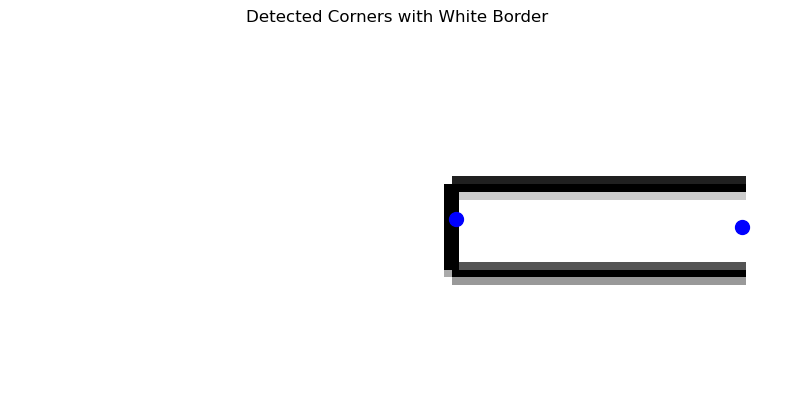

Image: Shapes\page_1_row_18.png
Number of corners detected: 2
Number of bends: 0



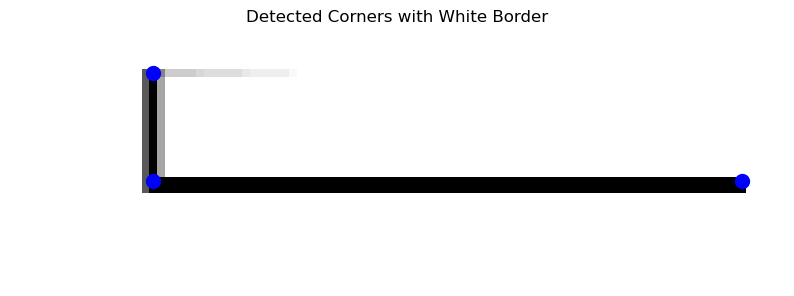

Image: Shapes\page_1_row_19.png
Number of corners detected: 3
Number of bends: 1



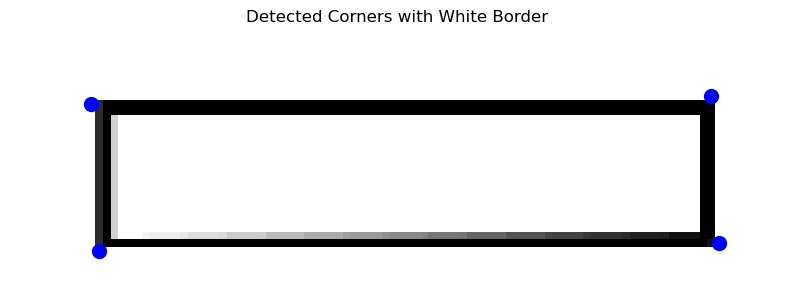

Image: Shapes\page_1_row_20.png
Number of corners detected: 4
Number of bends: 2



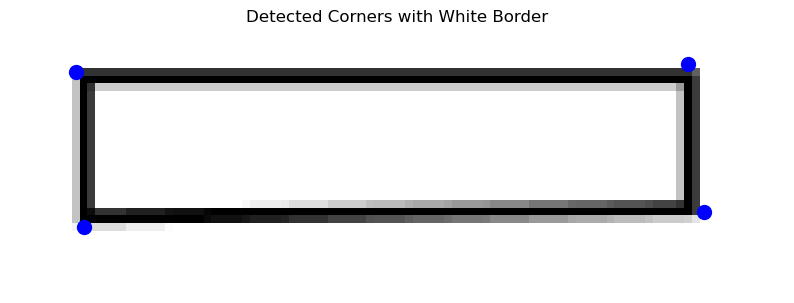

Image: Shapes\page_1_row_21.png
Number of corners detected: 4
Number of bends: 2



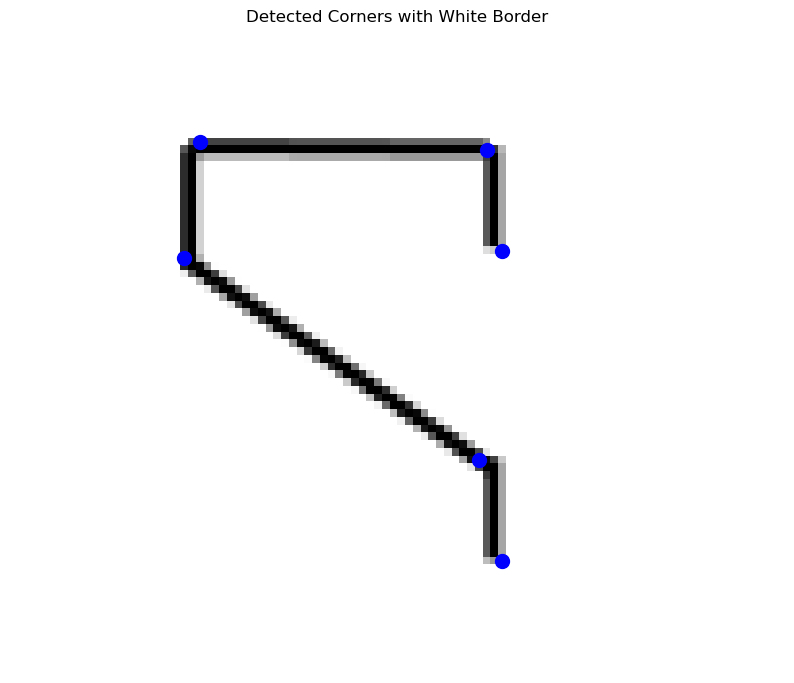

Image: Shapes\page_1_row_23.png
Number of corners detected: 6
Number of bends: 4



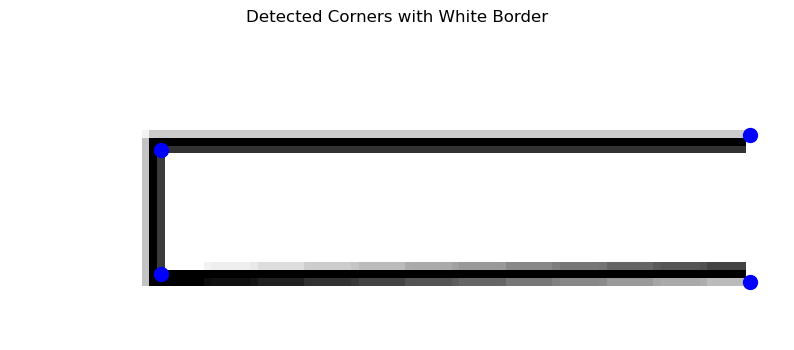

Image: Shapes\page_1_row_24.png
Number of corners detected: 4
Number of bends: 2



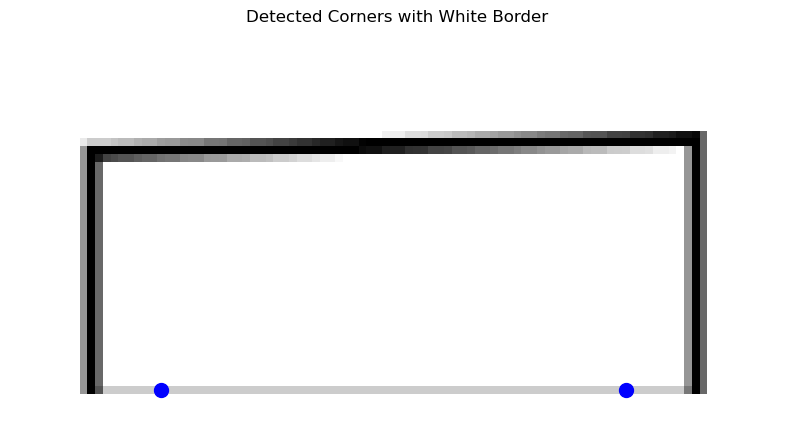

Image: Shapes\page_1_row_25.png
Number of corners detected: 2
Number of bends: 0



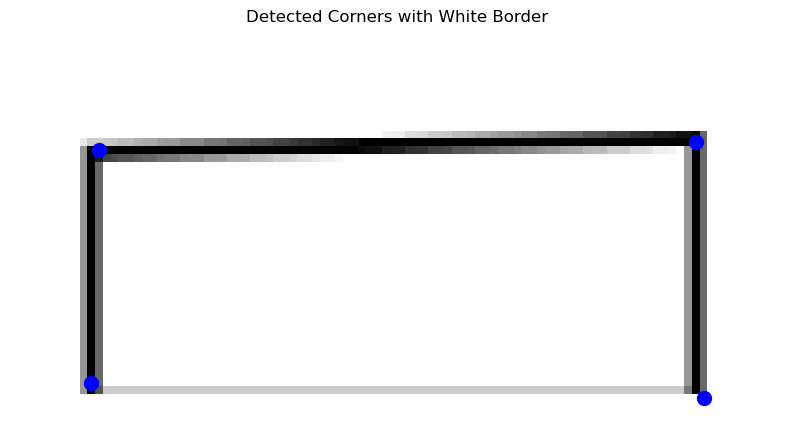

Image: Shapes\page_1_row_25.png
Number of corners detected: 4
Number of bends: 2



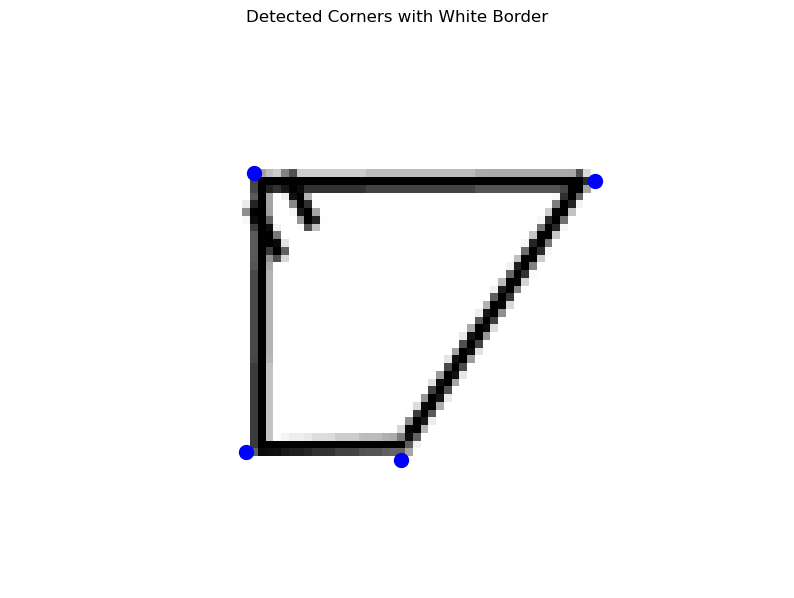

Image: Shapes\page_1_row_26.png
Number of corners detected: 4
Number of bends: 2



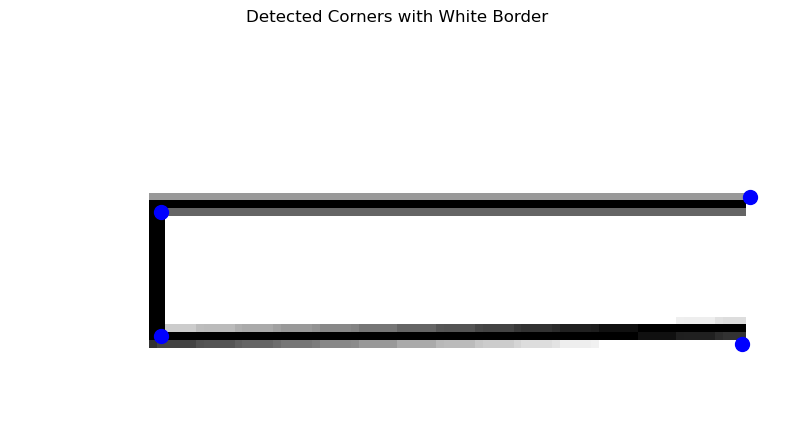

Image: Shapes\page_1_row_27.png
Number of corners detected: 4
Number of bends: 2



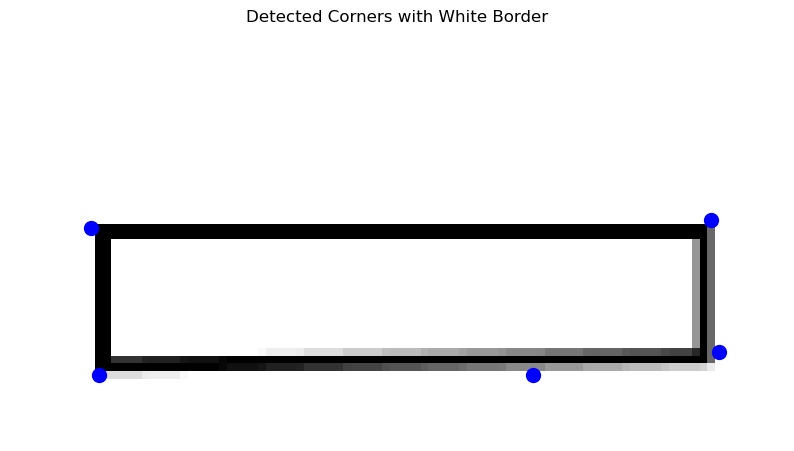

Image: Shapes\page_1_row_28.png
Number of corners detected: 5
Number of bends: 3



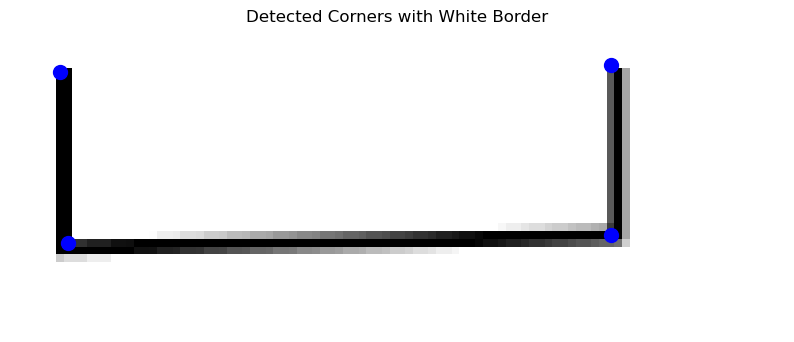

Image: Shapes\page_1_row_6.png
Number of corners detected: 4
Number of bends: 2



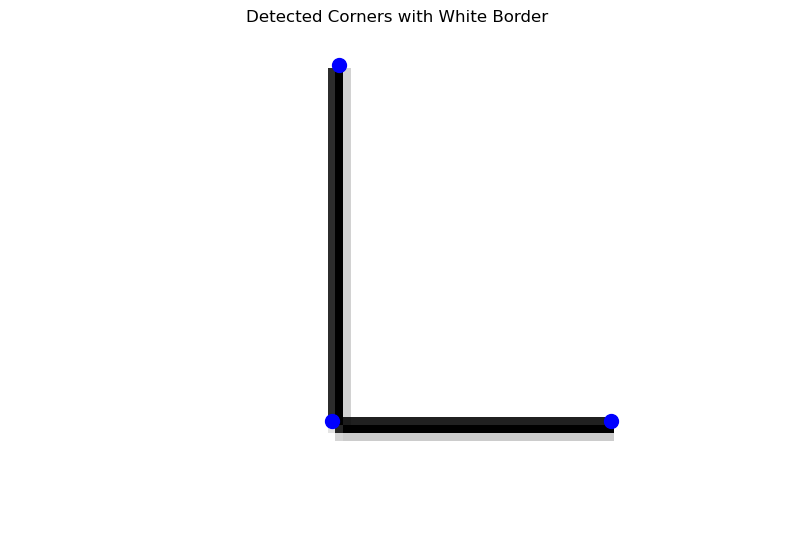

Image: Shapes\page_1_row_7.png
Number of corners detected: 3
Number of bends: 1



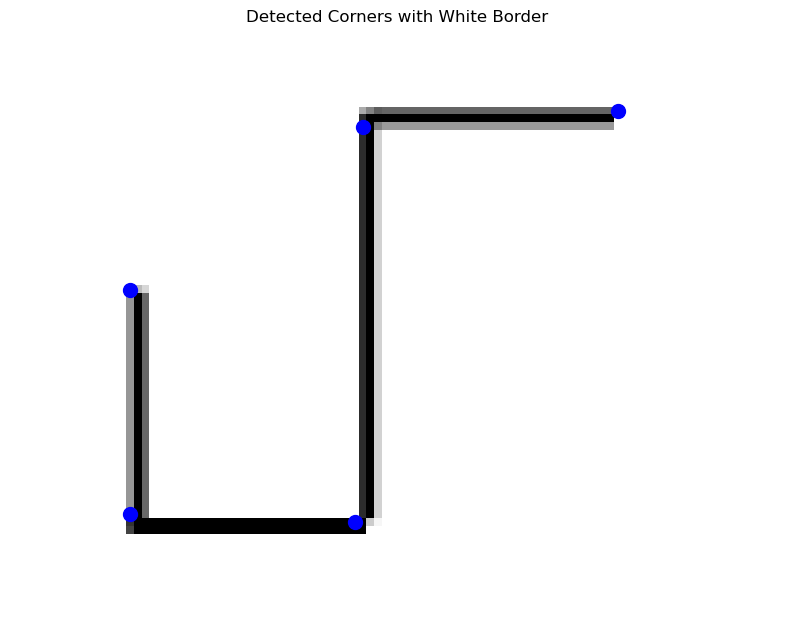

Image: Shapes\page_2_row_11.png
Number of corners detected: 5
Number of bends: 3



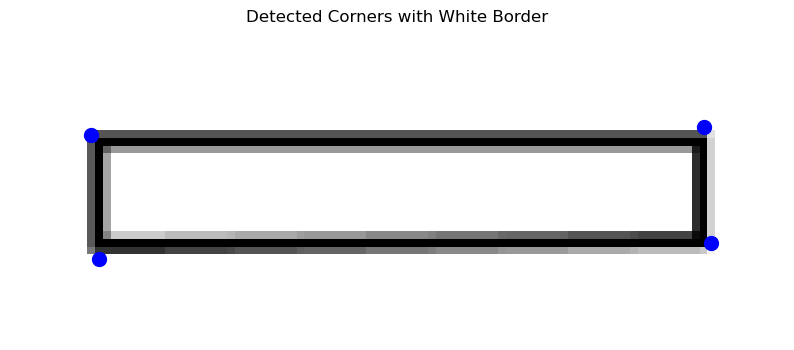

Image: Shapes\page_2_row_12.png
Number of corners detected: 4
Number of bends: 2



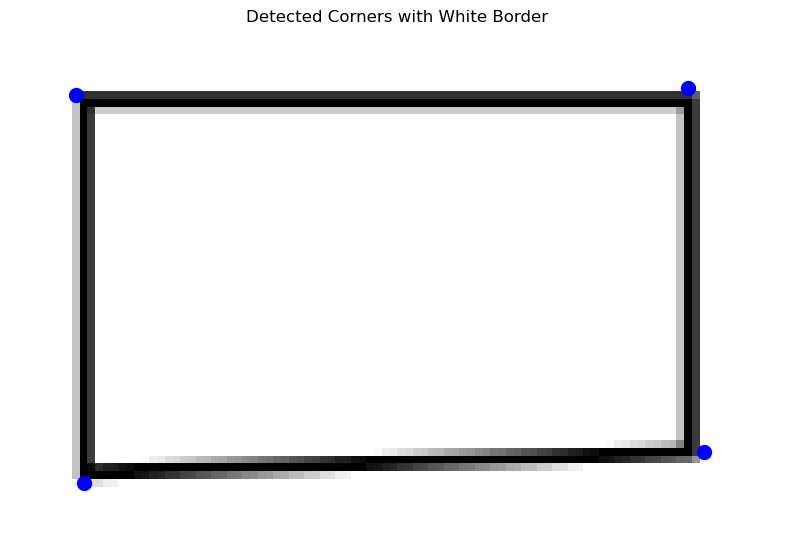

Image: Shapes\page_2_row_14.png
Number of corners detected: 4
Number of bends: 2



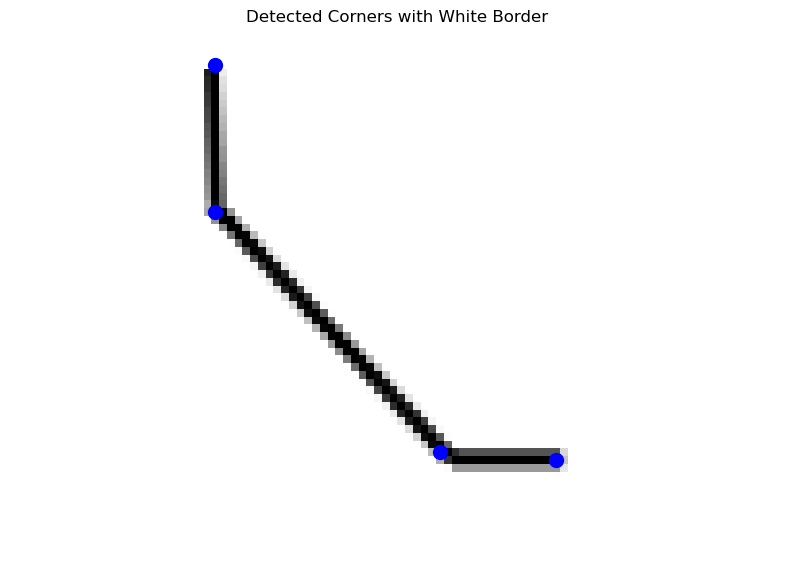

Image: Shapes\page_2_row_15.png
Number of corners detected: 4
Number of bends: 2



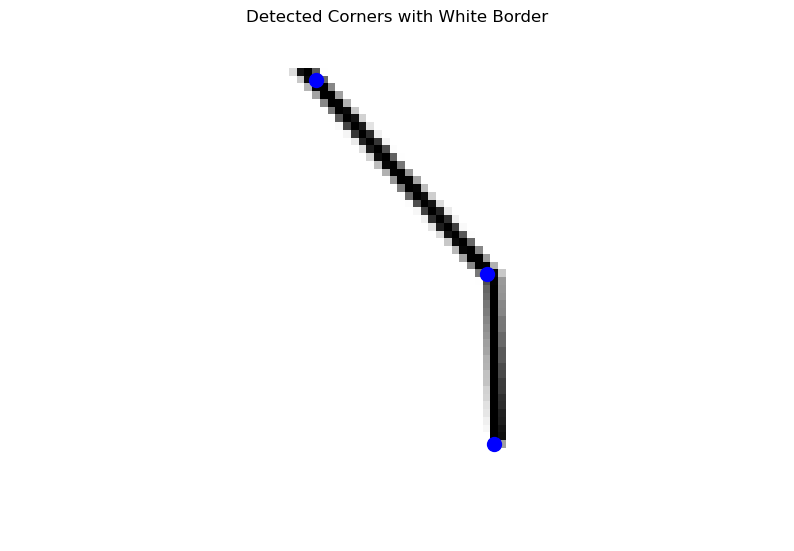

Image: Shapes\page_2_row_16.png
Number of corners detected: 3
Number of bends: 1



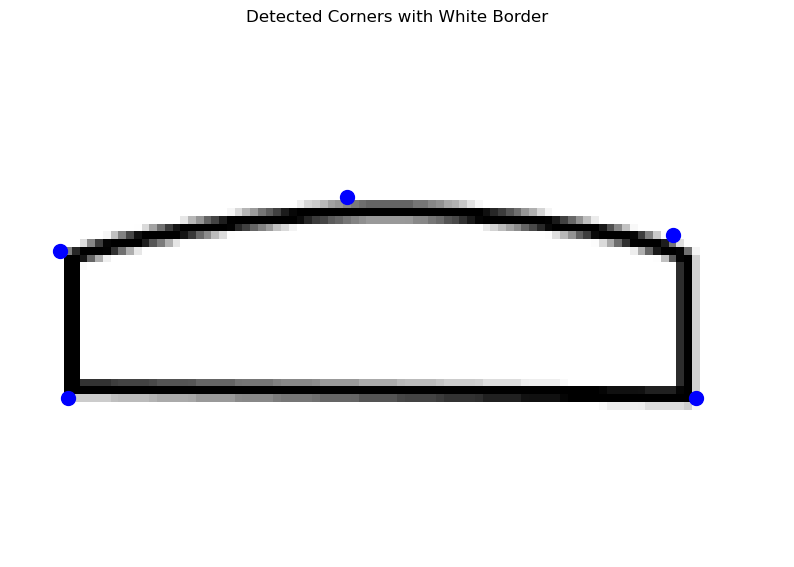

Image: Shapes\page_2_row_17.png
Number of corners detected: 5
Number of bends: 3



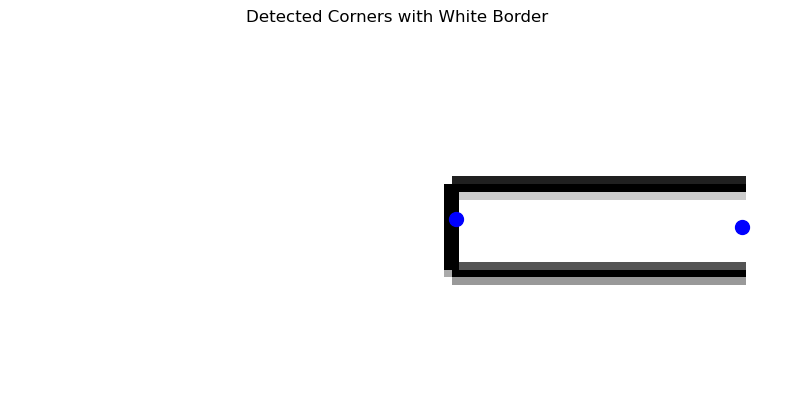

Image: Shapes\page_2_row_18.png
Number of corners detected: 2
Number of bends: 0



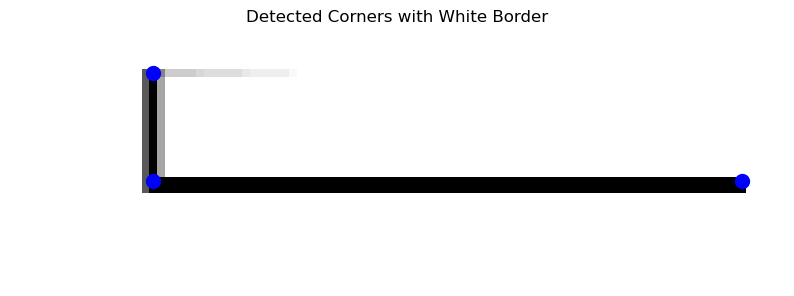

Image: Shapes\page_2_row_19.png
Number of corners detected: 3
Number of bends: 1



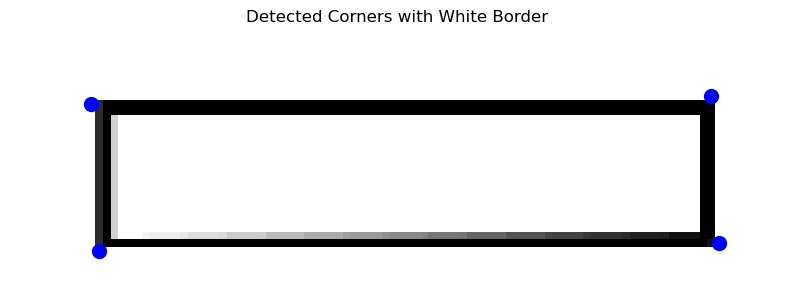

Image: Shapes\page_2_row_20.png
Number of corners detected: 4
Number of bends: 2



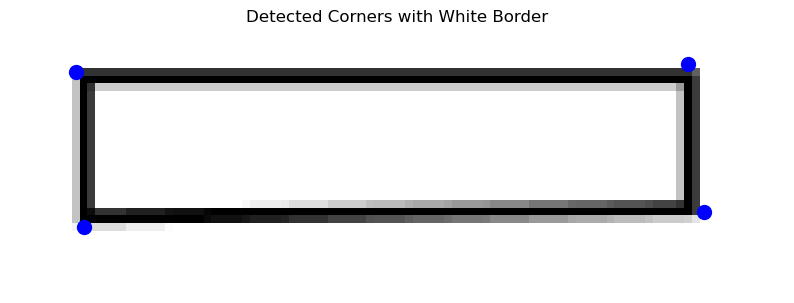

Image: Shapes\page_2_row_21.png
Number of corners detected: 4
Number of bends: 2



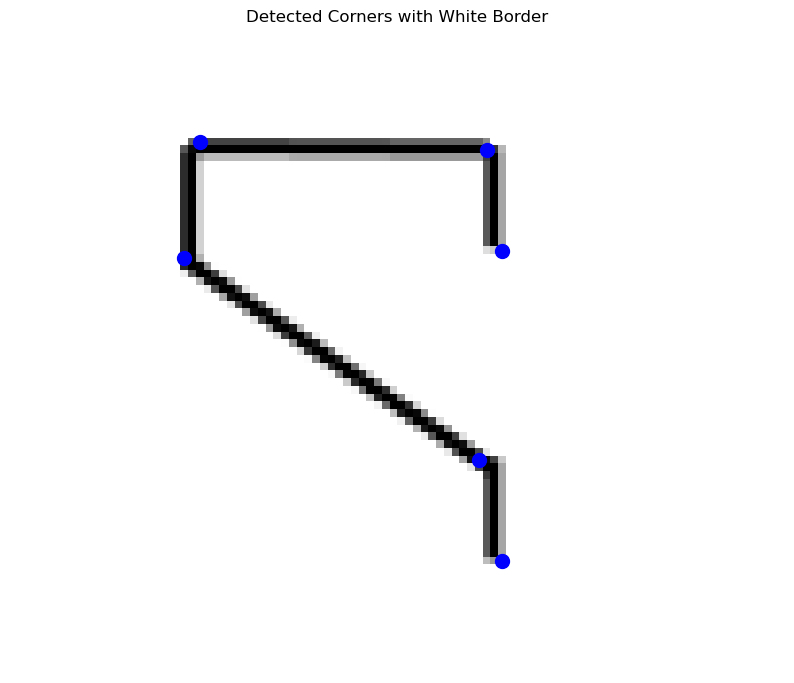

Image: Shapes\page_2_row_23.png
Number of corners detected: 6
Number of bends: 4



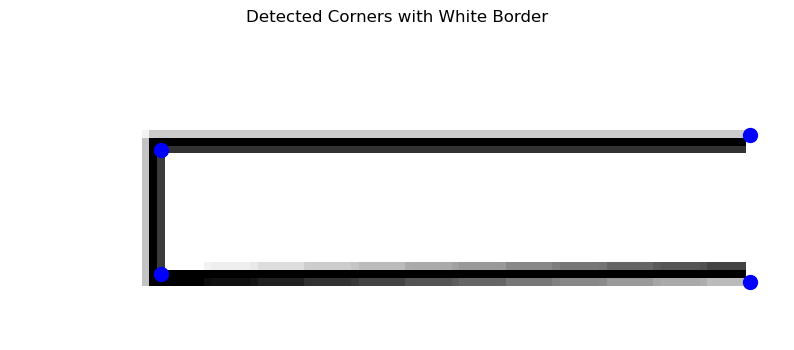

Image: Shapes\page_2_row_24.png
Number of corners detected: 4
Number of bends: 2



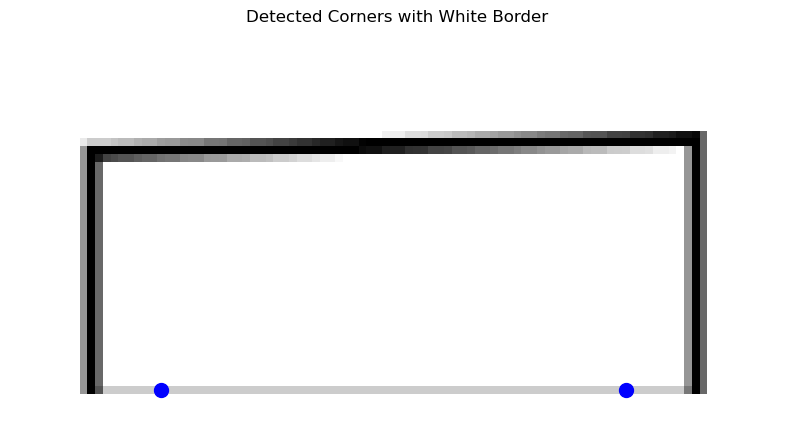

Image: Shapes\page_2_row_25.png
Number of corners detected: 2
Number of bends: 0



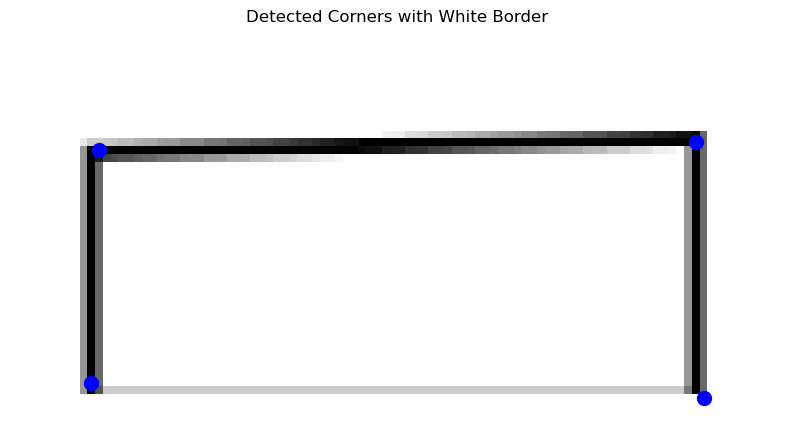

Image: Shapes\page_2_row_25.png
Number of corners detected: 4
Number of bends: 2



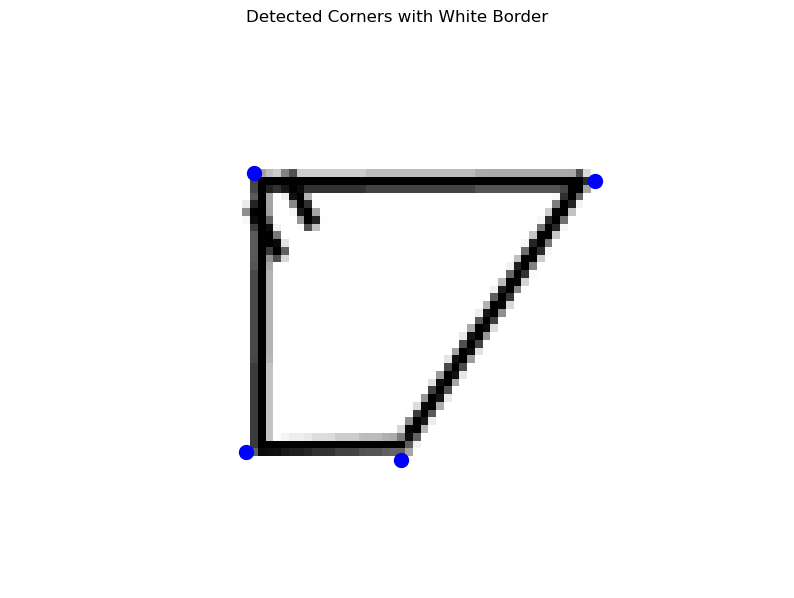

Image: Shapes\page_2_row_26.png
Number of corners detected: 4
Number of bends: 2



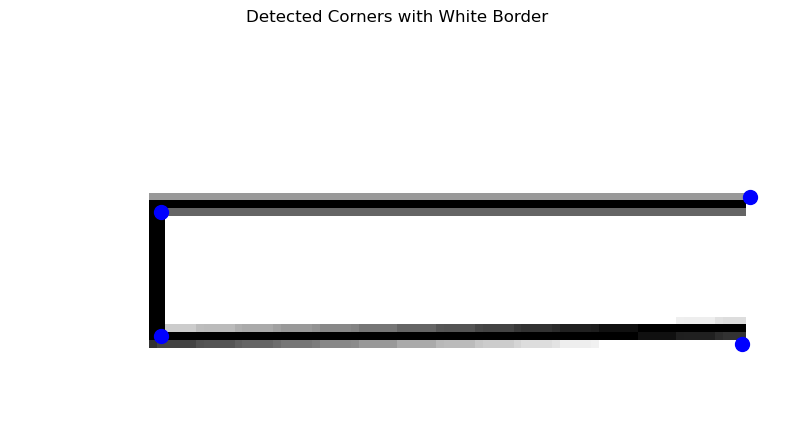

Image: Shapes\page_2_row_27.png
Number of corners detected: 4
Number of bends: 2



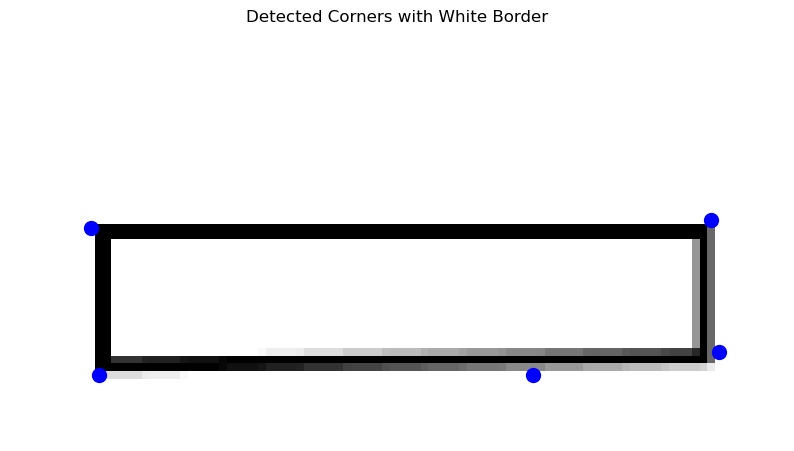

Image: Shapes\page_2_row_28.png
Number of corners detected: 5
Number of bends: 3



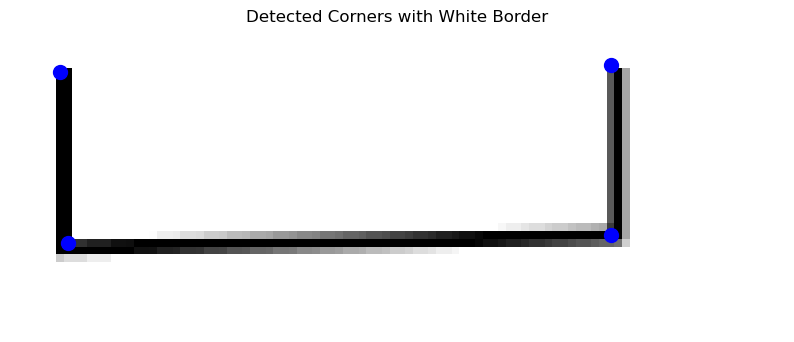

Image: Shapes\page_2_row_6.png
Number of corners detected: 4
Number of bends: 2



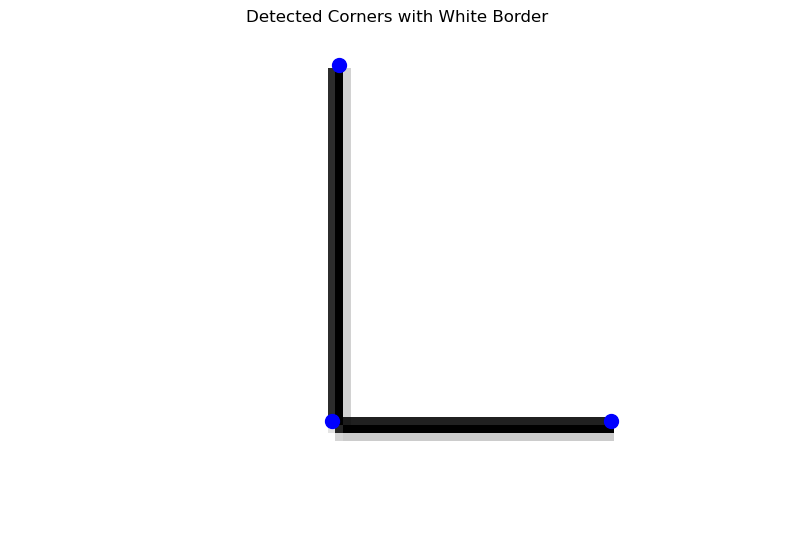

Image: Shapes\page_2_row_7.png
Number of corners detected: 3
Number of bends: 1



In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN

def add_white_border(image, border_thickness=5):
    """Add a white border by changing pixels around the edges of the image."""
    bordered_image = np.copy(image)
    bordered_image[:border_thickness, :] = 255  # Top border
    bordered_image[-border_thickness:, :] = 255  # Bottom border
    bordered_image[:, :border_thickness] = 255  # Left border
    bordered_image[:, -border_thickness:] = 255  # Right border
    return bordered_image

def preprocess_image(image, kernel_size=(3, 3), blur_ksize=(5, 5), block_size=31, C=10):
    """Preprocess image by applying Gaussian blur and adaptive thresholding."""
    blurred = cv2.GaussianBlur(image, blur_ksize, 0)
    binary_image = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )
    return binary_image

def find_contours(binary_image):
    """Find contours in the binary image."""
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def detect_corners_from_polygon(contour):
    """Detect corners by approximating the polygon and marking its vertices."""
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    corners = approx.reshape(-1, 2)
    return corners

def cluster_corners(corners, eps=10, min_samples=1):
    """Cluster nearby corners to ensure only one corner per vertex."""
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(corners)
    unique_corners = []
    for label in np.unique(db.labels_):
        cluster_points = corners[db.labels_ == label]
        centroid = np.mean(cluster_points, axis=0).astype(int)
        unique_corners.append(centroid)
    return np.array(unique_corners)

def process_image(image_path, preprocess_params={}):
    """Process a single image, add white border, detect corners, and count bends."""
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to read image: {image_path}")
            return

        # Add white border directly on the image
        bordered_image = add_white_border(image, border_thickness=5)

        binary_image = preprocess_image(bordered_image, **preprocess_params)
        contours = find_contours(binary_image)

        for contour in contours:
            corners = detect_corners_from_polygon(contour)
            corners = cluster_corners(corners)
            bends = len(corners) - 2

            plt.figure(figsize=(10, 10))
            plt.imshow(bordered_image, cmap='gray')
            plt.title('Detected Corners with White Border')
            plt.axis('off')

            for corner in corners:
                plt.plot(corner[0], corner[1], 'bo', ms=10)

            plt.show()

            print(f"Image: {image_path}")
            print(f"Number of corners detected: {len(corners)}")
            print(f"Number of bends: {bends}\n")

    except Exception as e:
        print(f"An error occurred while processing '{image_path}': {e}")

# Folder path containing the images
image_folder = "Shapes"

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        process_image(image_path)
